In [7]:
import pandas as pd

file_path = "web_service_dataset.csv"
df_original = pd.read_csv(file_path)

In [ ]:
df_original

In [8]:
# 3.1

from sklearn.preprocessing import StandardScaler

df_copy = df_original.copy()
# Define label (non-numerical) columns
label_columns = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'category', 'web_service', 'proto']

# Store the label columns in a separate DataFrame
df_labels = df_copy[label_columns]

# Drop label columns from the numerical dataset
df_copy = df_copy.drop(label_columns, axis=1)

# Standardize the numerical columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_copy)

# Create a new DataFrame with scaled numerical data
df_scaled = pd.DataFrame(scaled_data, columns=df_copy.columns)

# Add the label columns back to the scaled DataFrame
df_scaled = pd.concat([df_scaled, df_labels.reset_index(drop=True)], axis=1)

# Confirm scaling
print("Scaled data shape:", df_scaled.shape)

web_service_categories = df_scaled.groupby('web_service')['category'].nunique()

web_services_multiple_categories = web_service_categories[web_service_categories > 1]
print("Number of web services with multiple traffic categories:", len(web_services_multiple_categories))

most_categories_service = web_service_categories.idxmax()
most_categories_count = web_service_categories.max()

print("Web service with the most traffic categories:", most_categories_service)
print("Number of categories:", most_categories_count)



Scaled data shape: (2704839, 46)
Number of web services with multiple traffic categories: 5
Web service with the most traffic categories: DNS
Number of categories: 4


In [ ]:
df_scaled

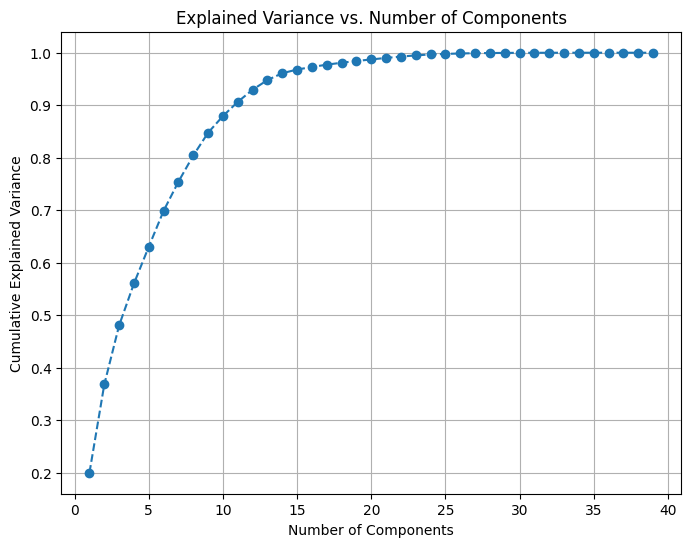

Number of components to save 90% variance: 11
Transformed dataset shape: (2704839, 18)


In [9]:
# 3.2

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Select only columns of the features (PCA works only with features)
df_scaled_features = df_scaled.drop(label_columns, axis=1)

# creating a PCA
pca = PCA()
pca.fit(df_scaled_features)

# computing cumulative explained variance
cumul_variance =  np.cumsum(pca.explained_variance_ratio_)

# make the plot of cumulative explained variance wrt number of components
# through this graph we can see how variance is increasing while adding new components
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumul_variance) + 1), cumul_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# here we need to see how many components we need to save with this variance threshold
threshold = 0.9

num_com = (cumul_variance >= threshold).argmax() + 1

print(f"Number of components to save 90% variance: {num_com}")

# so here we will create new PCA with fixed numbers of components
pca_selected = PCA(n_components=num_com)

# and transform data

pca_data = pca_selected.fit_transform(scaled_data)

# and here we will create a new dataset with different components and data
# columns is the main components

df_pca = pd.DataFrame(pca_data)


df_pca = pd.concat([df_pca, df_labels.reset_index(drop=True)], axis=1)

print("Transformed dataset shape:", df_pca.shape)



In [ ]:
# 3.2
df_pca

In [ ]:
# 3.3
import matplotlib.pyplot as plt

# Randomly select an equal number of samples from each category

sample = 10000

sampled_data = (
    df_pca.groupby('category')
    .head(sample)
    .reset_index(drop=True)
)

pca_1 = sampled_data[0]  # first component
pca_2 = sampled_data[1]  # second component
categories = sampled_data['category']  # select labels

print(categories.unique())

# Create a scatter plot
plt.figure(figsize=(10, 8))

for category in categories.unique():
    category_data = sampled_data[sampled_data['category'] == category]
    plt.scatter(category_data[0], category_data[1], label=category, alpha=0.7)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Scatter plot of the first and second components (2 new features)')
plt.legend(title='Category', loc='best')

plt.show()

# Can you visually tell apart different categories? - I need to think about it


In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

df_copy = df_pca.copy()

df_copy = df_copy[0:10000]

label_columns = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'category', 'web_service', 'proto']

features_dataset = df_copy.drop(label_columns, axis=1)

kmeans = KMeans(n_clusters=5, init='random', random_state=None, n_init=1)

kmeans.fit(features_dataset)

kmeans_results = []

for k in range(2, 21):
    kmeans_results.append(KMeans(n_clusters=k).fit(features_dataset))

fig, axs = plt.subplots(1,2, figsize=(8, 3.5))

axs[0].plot(
    [k for k in range(2,21)],
    [result.inertia_ for result in kmeans_results]
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].grid()

axs[1].plot(
    [k for k in range(2,21)],
    [silhouette_score(features_dataset, result.labels_) for result in kmeans_results]
)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].grid()

plt.tight_layout()
plt.show()

# Here the two plots show contrasting objectives: for clustering error, increasing k will improve the results, while for silhouette increasing k will worsen the results. For clustering error, the addition of an additional cluster cannot result in a larger average distance from the points to their corresponding cluster means. It naturally follows that the raw clustering error will always favour a larger number. Hence, by looking at the silhouette a small number of k is more appropriate.

# Helper function to plot the clustering -- only 2 dimensione (if more, it will plot only the first two columns).
def plot_clustering(X, labels, centers=None, title="", subplot=None):

    # Plot in given subplot
    if subplot:
        plt.subplot(subplot)

    # Plot data with labels as color
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels)

    # Plot centers if given
    if centers is not None:
        plt.scatter(
            centers[:, 0], centers[:, 1], c="red", s=150, alpha=0.9, label="Centers"
        )

    # Set title
    plt.title(title)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])

plot_clustering(features_dataset, kmeans.labels_, kmeans.cluster_centers_)